In [ ]:
!pip show peft transformers

Name: peft
Version: 0.15.2
Summary: Parameter-Efficient Fine-Tuning (PEFT)
Home-page: https://github.com/huggingface/peft
Author: The HuggingFace team
Author-email: benjamin@huggingface.co
License: Apache
Location: /usr/local/lib/python3.11/dist-packages
Requires: accelerate, huggingface_hub, numpy, packaging, psutil, pyyaml, safetensors, torch, tqdm, transformers
Required-by: 
---
Name: transformers
Version: 4.52.4
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [1]:
import os
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU. Using CPU.")

GPU is available!
Using device: Tesla T4


In [3]:
!pip install gdown --quiet
!gdown '1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw'

Downloading...
From (original): https://drive.google.com/uc?id=1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw
From (redirected): https://drive.google.com/uc?id=1bzTrvDtnVOeL9Ft_6omSKumvU8qaO3vw&confirm=t&uuid=e7dac1a9-e906-4b23-bae1-09ee49e3f1e6
To: /content/final_data_with_summarization.csv
100% 288M/288M [00:04<00:00, 66.8MB/s]


# 1. Loading the Data

In [4]:
df = pd.read_csv(r"final_data_with_summarization.csv")

In [5]:
df["input"] = df["text_summary"].fillna(df["text"])

In [6]:
df["input"].isnull().sum()

np.int64(39)

In [7]:
X = df["title"].fillna("") + " " + df["input"].fillna("")

In [8]:
Y = df["label"]

In [9]:
X.values[10]

'U.N. seeks humanitarian pause in Sanaa where streets "battlegrounds" GENEVA (Reuters) - The United Nations called on Monday for a humanitarian pause in the Yemeni capital of Sanaa on Tuesday to allow civilians to leave their homes, aid workers to reach them, and the wounded to get medical care. Jamie McGoldrick, U.N. humanitarian coordinator in Yemen, said in a statement that the streets of Sanaa had become  battlegrounds  and that aid workers  remain in lockdown .  Thus, I call on all parties to the conflict to urgently enable a humanitarian pause on Tuesday 5 December, between 10:00 a.m. and 16:00 p.m. to allow civilians to leave their homes and seek assistance and protection and to facilitate the movement of aid workers to ensure the continuity of life-saving programs,  he said.  McGoldrick warned the warring parties that any deliberate attacks against civilians, and against civilian and medical infrastructure, are  clear violations of international humanitarian law and may constit

In [10]:
Y[10]

np.int64(0)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [12]:
X_train.shape, X_val.shape, X_test.shape

((49043,), (8655,), (14425,))

In [13]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

<b> 0 = Real, 1 = Fake

# 2. Preparing Data Loaders and Model

We use the [sentence-transformers/all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) embedding model from huggingface and fine tune it.

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [33]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, EarlyStoppingCallback
from peft import LoraConfig, get_peft_model
from peft import PeftModel

In [43]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: "Real", 1: "Fake"},
    label2id={"Real": 0, "Fake": 1}
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# configuration for LORA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="lora_only",
    task_type="SEQ_CLS",
    target_modules=["query", "value"],
)

In [42]:
# Apply LoRA to the model
model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()

trainable params: 152,834 || all params: 22,862,212 || trainable%: 0.6685


In [19]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 152834


In [20]:
class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [21]:
train_dataset = CustomTextDataset(list(X_train), list(y_train), tokenizer)

In [22]:
val_dataset = CustomTextDataset(list(X_val), list(y_val), tokenizer)

In [23]:
test_dataset = CustomTextDataset(list(X_test), y_test, tokenizer)

In [24]:
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
for feature in train_loader:
  break

In [26]:
feature

{'input_ids': tensor([[  101,  3577,  1005,  ...,     0,     0,     0],
         [  101,  1057,  1012,  ...,     0,     0,     0],
         [  101,  2062,  2084,  ...,     0,     0,     0],
         ...,
         [  101, 12476,   999,  ...,     0,     0,     0],
         [  101,  8817,  2000,  ...,     0,     0,     0],
         [  101,  3519,  3791,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
         0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
         0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
         0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
device

device(type='cuda')

In [29]:
model.to(device)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 384, padding_idx=0)
          (position_embeddings): Embedding(512, 384)
          (token_type_embeddings): Embedding(2, 384)
          (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-5): 6 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=384, out_features=384, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default):

Perfect!!! Our forward pass works as expected. Now, lets create some helper functions and train our model.

# 3. Helper Functions

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
def perform_deep_test_analysis(y_test, test_preds: np.array, test_preds_proba: np.array, model_name: str) -> None:
    """"
    This function takes in a model object and model name, and performs a deep analysis on the model's performance on the test set.
    It prints classification report, confusion matrix, ROC AUC score and plots the ROC curve.
    """
    cm = confusion_matrix(y_test, test_preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n")
    print("FOR TESTING SET: ")
    print(classification_report(y_test, test_preds))
    print("\n")

    print(f"ROC AUC Score: {roc_auc_score(y_test, test_preds_proba):.2%}")
    print("\n")

    fpr, tpr, _ = roc_curve(y_test, test_preds_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# 4. Model Training

In [ ]:
!pip install evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.4 MB/s eta 0:00:00


In [ ]:
import evaluate
from sklearn.metrics import accuracy_score

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels,preds)

    return {"accuracy":acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="./lora_model_output",
    overwrite_output_dir=True,
    num_train_epochs=15,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate = 0.001,
    weight_decay=0.01,
    eval_strategy="epoch",
    eval_steps=1,
    save_strategy="epoch",
    save_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # Lower loss is better
    fp16=True,  # Enable mixed precision training if supported
    report_to="none", # i dont need to add logging to weights and biases
)

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=5,
        )
    ],
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.133831,0.948122
2,No log,0.108215,0.955633
3,0.175200,0.112923,0.954246
4,0.175200,0.089607,0.962681
5,0.175200,0.093231,0.963720
6,0.083800,0.081844,0.968226
7,0.083800,0.083138,0.967880
8,0.062600,0.092794,0.963720
9,0.062600,0.084504,0.969266
10,0.062600,0.088442,0.969613


TrainOutput(global_step=2112, training_loss=0.08923138768383951, metrics={'train_runtime': 3875.1484, 'train_samples_per_second': 189.837, 'train_steps_per_second': 0.743, 'total_flos': 1.813770801415373e+16, 'train_loss': 0.08923138768383951, 'epoch': 11.0})

In [ ]:
model.save_pretrained("lora_finetuned_model")

In [38]:
# from transformers import AutoModelForCausalLM  # or the appropriate model class
# base_model = AutoModelForCausalLM.from_pretrained(model_name)

In [49]:
model = PeftModel.from_pretrained(base_model, "LORA").to(device)

In [59]:
def make_predictions_using_NN(model, data_loader):
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(data_loader):
            # xb = xb.to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            output = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = output.logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    return all_preds, all_probs

In [60]:
# a = make_predictions_using_NN(model, train_loader)

In [61]:
train_preds, train_probs_1dCNN = make_predictions_using_NN(model, train_loader)
val_preds, val_probs_1dCNN = make_predictions_using_NN(model, val_loader)
test_preds, test_probs_1dCNN = make_predictions_using_NN(model, test_loader)

100%|██████████| 57/57 [01:32<00:00,  1.61s/it]


In [62]:
print("Training performance")
print(classification_report(y_train, train_preds))

Training performance
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     23853
           1       0.99      0.97      0.98     25190

    accuracy                           0.98     49043
   macro avg       0.98      0.98      0.98     49043
weighted avg       0.98      0.98      0.98     49043



In [63]:
print("Val performance")
print(classification_report(y_val, val_preds))

Val performance
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4097
           1       0.97      0.96      0.97      4558

    accuracy                           0.96      8655
   macro avg       0.96      0.96      0.96      8655
weighted avg       0.96      0.96      0.96      8655



In [64]:
print("Test performance")
print(classification_report(y_test, test_preds))

Test performance
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7078
           1       0.98      0.96      0.97      7347

    accuracy                           0.97     14425
   macro avg       0.97      0.97      0.97     14425
weighted avg       0.97      0.97      0.97     14425



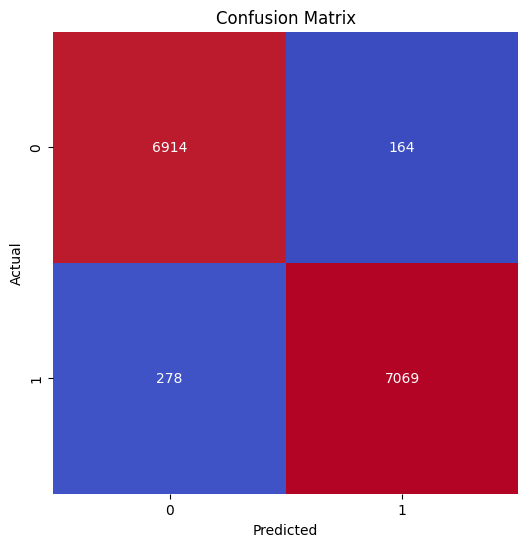



FOR TESTING SET: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7078
           1       0.98      0.96      0.97      7347

    accuracy                           0.97     14425
   macro avg       0.97      0.97      0.97     14425
weighted avg       0.97      0.97      0.97     14425



ROC AUC Score: 99.65%




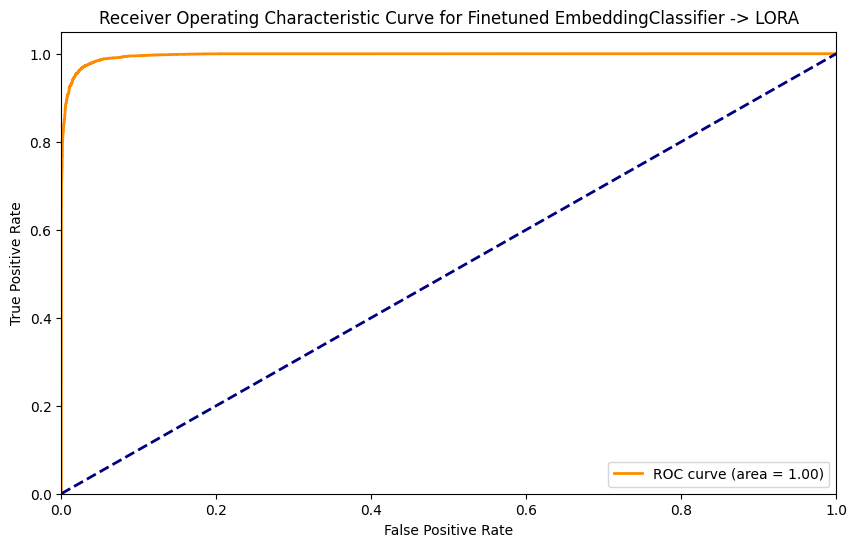

In [65]:
perform_deep_test_analysis(y_test, test_preds, test_probs_1dCNN[:, 1], "Finetuned EmbeddingClassifier -> LORA")